### Importing the Libraries

In [ ]:
# Load essential libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import glob,string
import codecs
from tqdm import tqdm
from PIL import Image

from torchinfo import summary

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset



In [3]:
def contructDataframe(file_list):
    """
    this function builds a data frame which contains 
    the path to image and the tag/object name using the prefix of the image name
    """
    data=[]
    for file in tqdm(file_list):
        prefix = file.split("/")[-1].split("__")[0]
        label = int(prefix.lstrip(string.ascii_letters)) -1 # for zero-based for pytorch crossentropy
        data.append((file,label,prefix))
    return pd.DataFrame(data,columns=['path','label','class'])


In [4]:
class CreateDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        df = dataframe.reset_index(drop=True)
        self.paths = df["path"].tolist()
        self.targets = df["label"].astype(int).tolist()
        self.transform = transform

        label_to_class = dict(zip(df["label"], df["class"]))
        self.classes = [label_to_class[i] for i in sorted(label_to_class.keys())]
        self.class_to_idx = {name: i for i, name in enumerate(self.classes)}

    def __len__(self): 
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(self.targets[idx], dtype=torch.long)

### Loading the Dataset Coil-100 dataset

In [6]:
def get_coil100_train_valid_loader(batch_size, percent_train=0.8, shuffle=True, random_seed=42):
    
    path = 'coil-100/*.png'
    files=glob.glob(path)
    
    normalize = transforms.Normalize(
        mean=[0.3443, 0.3809, 0.4082],
        std=[0.1832, 0.1559, 0.1455]
    )

    transform = transforms.Compose([
        transforms.Resize((72, 72)),# resize to 72x72 to follow the architetcture of the CNN model in the fully connected layer for easy testing of both datasets
        transforms.ToTensor(),
        normalize,
    ])

    dataset = CreateDataset(contructDataframe(files), transform=transform)
    classes = dataset.classes

    # --- Define split sizes ---
    dataset_size = len(dataset)   
    train_size = int(percent_train * dataset_size)   # 70%
    val_size   = int(0.15 * dataset_size)  # 15%
    test_size  = dataset_size - train_size - val_size  # rest

    # --- Split dataset ---
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)  # reproducible
    )

    # --- Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return train_loader, valid_loader, test_loader, classes



### Loading the Dataset EuroSAT dataset

In [7]:
def get_EuroSAT_train_valid_loader(data_dir, batch_size, percent_train=0.8, shuffle=True, random_seed=42):
    # Define transforms (resize + normalization) ---
    normalize = transforms.Normalize(
        mean=[0.3443, 0.3809, 0.4082],
        std=[0.1832, 0.1559, 0.1455]
    )

    transform = transforms.Compose([
        transforms.Resize((72, 72)), # Feels wrong to resize to 72x72 when org Eorsat is 64x64, i only do it to follow bad architecture defined later of fully connected layer
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    # load the dataset
    dataset = datasets.EuroSAT(root=data_dir, download=True, transform=transform,)
    print(type(dataset))
    classes = dataset.classes

    # --- Define split sizes ---
    dataset_size = len(dataset)   # ~27,000 images
    train_size = int(percent_train * dataset_size)   # 70%
    val_size   = int(0.15 * dataset_size)  # 15%
    test_size  = dataset_size - train_size - val_size  # rest

    # --- Split dataset ---
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)  # reproducible
    )

    # --- Create DataLoaders ---
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)

    return (train_loader, valid_loader, test_loader, classes)


# Chose a Dataset by uncoment one and comment other to be used for the ANN or CNN model to classifie

In [8]:
# load EuroSAT dataset
train_loader, valid_loader, test_loader, classes = get_EuroSAT_train_valid_loader(data_dir = './data',batch_size = 128, percent_train=0.8)

# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)

print(images.shape)

<class 'torchvision.datasets.eurosat.EuroSAT'>
torch.Size([128, 3, 72, 72])


In [ ]:
# load Coil-100 dataset
train_loader, valid_loader, test_loader, classes = get_coil100_train_valid_loader(batch_size = 128, percent_train=0.8)

# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)

print(images.shape)


100%|██████████| 7200/7200 [00:00<00:00, 1038194.06it/s]
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/anaconda3/envs/PyTorch/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/anaconda3/envs/PyTorch/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'CreateDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

### Visualize images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.052653283..1.3073446].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02226752..1.1336534].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10789132..2.0862179].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10616812..1.5617722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07405922..2.5336769].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11859429..1.4290836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.052

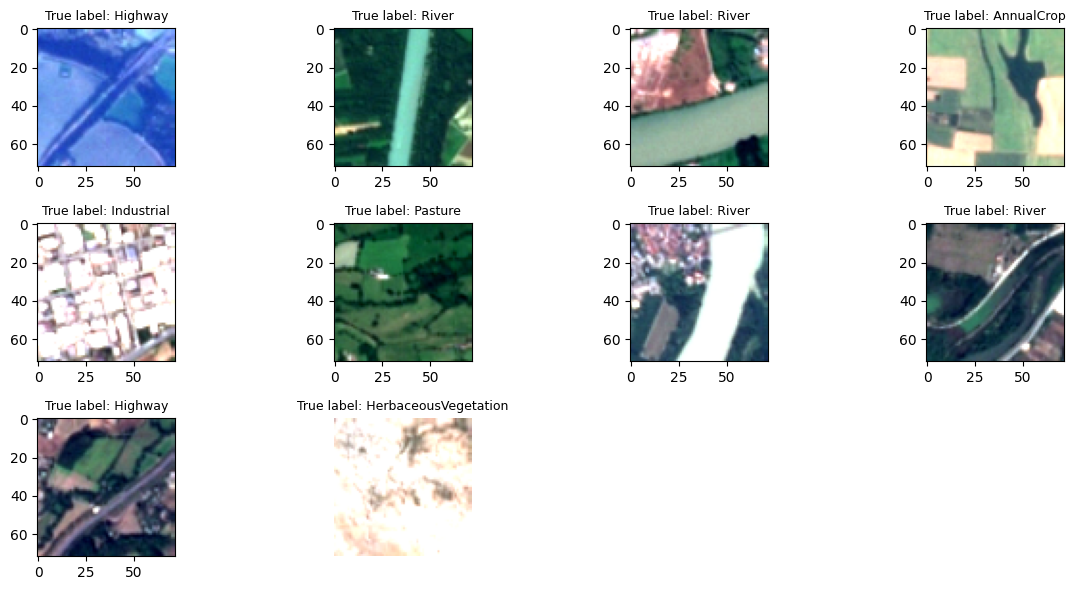

In [9]:
# Get a batch of images
examples = iter(train_loader)
images, labels = next(examples)

# Denormalize helper
def denormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization
    return img

# Plot some images
def plot_images(images, labels, classes, preds=None, num_images=5):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(int(np.sqrt(num_images)), int(np.ceil(num_images/np.sqrt(num_images))), i+1)
        img = images[i]
        img = denormalize(img)
        npimg = img.permute(1, 2, 0).numpy()
        plt.imshow(npimg)
      
        true_label = classes[labels[i]]
        if preds is not None:
            pred_label = classes[preds[i]]
            title = f"True label: {true_label}\nPredicted label: {pred_label}"
            color = "green" if labels[i] == preds[i] else "red"
            plt.title(title, color=color, fontsize=9)
        else:
            plt.title(f"True label: {true_label}", fontsize=9)

    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Get one batch from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

plot_images(images, labels, classes, num_images=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054376423..2.5336769].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.031247348..1.7116138].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.052653283..1.2192771].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18108892..2.2895741].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.36401188..2.4855676].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11859429..0.898188].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.09

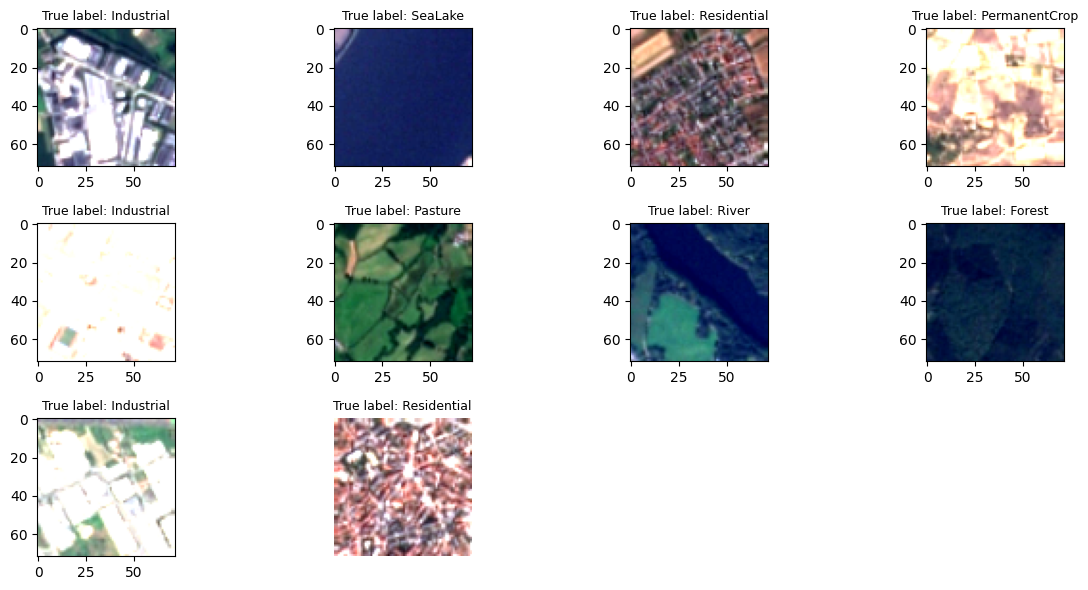

In [10]:
# Get one batch from the train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)
plot_images(images, labels, classes, num_images=10)

In [11]:
images = images.view(images.shape[0], -1)
print(images.shape)


num_classes = len(classes)
print(num_classes)

torch.Size([128, 15552])
10


In [12]:
class BaseANN(nn.Module):
    def __init__(self, num_classes: int ,p: float = 0.3):
        super().__init__()
        self.flatten = nn.Flatten()
        self.lin1 = nn.Linear(in_features=15552, out_features=64)
        self.drop1 = nn.Dropout(p)
        self.lin2 = nn.Linear(in_features=64, out_features=32)
        self.drop2 = nn.Dropout(p)
        self.lin3 = nn.Linear(in_features=32, out_features=num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        x = F.relu(self.lin2(x))
        x = self.drop2(x)
        x = self.lin3(x)
        return x
 
        

In [67]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes:int):
        super().__init__()
        # output size after conv layer: (W−K+2*P)/S +1
        
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,stride=1, padding=1) # (W−K+2*P)/S +1 = (72-3+2*1)/1 +1 = 72
        self.BatchNorm1 = nn.BatchNorm2d(32)
        self.Relu1 = nn.ReLU()
        self.MaxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)# (W−S)/S +1 = (72-2)/2 + 1 = 36
        
        self.Conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1, padding=1) # (W−K+2*P)/S +1 = (36-3+2*1)/1 +1 = 36
        self.BatchNorm2 = nn.BatchNorm2d(64)
        self.Relu2 = nn.ReLU()
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # (W−S)/S +1 = (36-2)/2 + 1 = 18
        self.Droput1 = nn.Dropout(0.3)
        
        self.Flatten = nn.Flatten() # batchsize, channels * w * h = Batchsize,  64*18*18 = 20736
        self.Fc1 = nn.Linear(in_features=64*18*18, out_features=128) # Amount of parameters = 20736*128 + 128 = 2,654,336
        self.Droput2 = nn.Dropout(0.5)
        self.Relu3 = nn.ReLU()
        self.Fc2 = nn.Linear(in_features=128, out_features=num_classes)
    
    def forward(self, x):
        x = self.Conv1(x)
        x = self.BatchNorm1(x)
        x = self.Relu1(x)
        x = self.MaxPool1(x)
        
        x = self.Conv2(x)
        x = self.BatchNorm2(x)
        x = self.Relu2(x)
        x = self.MaxPool2(x)
        x = self.Droput1(x)
        
        x = self.Flatten(x)
        x = self.Fc1(x)
        x = self.Droput2(x)
        x = self.Relu3(x)
        x = self.Fc2(x)
        return x
   
    


        


### Train and validate

In [14]:
def train(model, train_loader, valid_loader, num_epochs=10):
  train_losses, valid_losses = [], []


  for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    total_samples = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_size = labels.size(0)
      running_loss += loss.item() * batch_size
      total_samples += batch_size

    epoch_train_loss = running_loss / total_samples if total_samples > 0 else 0.0
    train_losses.append(epoch_train_loss)

    # Validation after each epoch
    val_loss, val_acc = evaluate(model, valid_loader)
    valid_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.2f}%")

  plot_loss(train_losses, valid_losses)
  return train_losses, valid_losses

### Test your model

In [15]:
def plot_loss(train_losses, val_losses):
    """
    Plot training and validation loss over epochs.

    Args:
        train_losses (list): Training loss per epoch
        val_losses (list): Validation loss per epoch
    """
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Training Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [16]:
# --- Evaluation ---
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    accuracy = 100.0 * total_correct / total_samples if total_samples > 0 else 0.0
    model.train()
    return avg_loss, accuracy


# Choose with type of model to train ANN or CNN

In [63]:
# just for checking if GPU is available MAC M1/M2 or CUDA GPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)


mps


# start the training & evaluation of the model and then final test the model to predict the classes

In [68]:
num_classes=len(classes)

#model = BaseANN(num_classes).to(device)
model = BaseCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Run training ---
train(model, train_loader, valid_loader, num_epochs=20)

# --- Test accuracy ---
_,test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

Epoch 1/20 - Train Loss: 1.5007 - Val Loss: 0.9309 - Val Acc: 67.01%


KeyboardInterrupt: 

## normal architectture

Epoch 1/10 - Train Loss: 1.6705 - Val Loss: 1.1200 - Val Acc: 61.85%
Epoch 2/10 - Train Loss: 1.2691 - Val Loss: 0.9313 - Val Acc: 67.73%
Epoch 3/10 - Train Loss: 1.1751 - Val Loss: 0.8681 - Val Acc: 69.21%
Epoch 4/10 - Train Loss: 1.1173 - Val Loss: 0.7932 - Val Acc: 73.68%
Epoch 5/10 - Train Loss: 1.0634 - Val Loss: 0.7124 - Val Acc: 75.06%
Epoch 6/10 - Train Loss: 1.0284 - Val Loss: 0.6990 - Val Acc: 76.79%
Epoch 7/10 - Train Loss: 0.9915 - Val Loss: 0.6679 - Val Acc: 77.38%
Epoch 8/10 - Train Loss: 0.9584 - Val Loss: 0.6480 - Val Acc: 77.04%
Epoch 9/10 - Train Loss: 0.9276 - Val Loss: 0.5975 - Val Acc: 79.36%
Epoch 10/10 - Train Loss: 0.9062 - Val Loss: 0.6402 - Val Acc: 77.85%

Test Accuracy: 78.59%

# No Dropout Layers

Epoch 1/20 - Train Loss: 1.4225 - Val Loss: 0.8233 - Val Acc: 71.11%
Epoch 2/20 - Train Loss: 0.7364 - Val Loss: 0.7211 - Val Acc: 74.44%
Epoch 3/20 - Train Loss: 0.6307 - Val Loss: 0.5788 - Val Acc: 79.21%
Epoch 4/20 - Train Loss: 0.5527 - Val Loss: 0.7000 - Val Acc: 75.21%
Epoch 5/20 - Train Loss: 0.4878 - Val Loss: 0.5249 - Val Acc: 81.85%
Epoch 6/20 - Train Loss: 0.4484 - Val Loss: 0.5122 - Val Acc: 81.85%
Epoch 7/20 - Train Loss: 0.4358 - Val Loss: 0.5440 - Val Acc: 81.23%
Epoch 8/20 - Train Loss: 0.3724 - Val Loss: 0.4103 - Val Acc: 86.07%
Epoch 9/20 - Train Loss: 0.3500 - Val Loss: 0.4395 - Val Acc: 84.91%
Epoch 10/20 - Train Loss: 0.3135 - Val Loss: 0.3964 - Val Acc: 86.35%
Epoch 11/20 - Train Loss: 0.3243 - Val Loss: 0.4172 - Val Acc: 86.37%
Epoch 12/20 - Train Loss: 0.2914 - Val Loss: 0.4916 - Val Acc: 84.54%
Epoch 13/20 - Train Loss: 0.2893 - Val Loss: 0.4431 - Val Acc: 84.79%
Epoch 14/20 - Train Loss: 0.2354 - Val Loss: 0.3810 - Val Acc: 87.65%
Epoch 15/20 - Train Loss: 0.2656 - Val Loss: 0.4047 - Val Acc: 86.89%
Epoch 16/20 - Train Loss: 0.2041 - Val Loss: 0.4353 - Val Acc: 85.90%
Epoch 17/20 - Train Loss: 0.2025 - Val Loss: 0.3720 - Val Acc: 88.44%
Epoch 18/20 - Train Loss: 0.2132 - Val Loss: 0.3738 - Val Acc: 88.27%
Epoch 19/20 - Train Loss: 0.1842 - Val Loss: 0.3819 - Val Acc: 87.80%
Epoch 20/20 - Train Loss: 0.1637 - Val Loss: 0.4546 - Val Acc: 86.77%

Test Accuracy: 85.93%

## No Batchnorm architecture

Epoch 1/20 - Train Loss: 1.2370 - Val Loss: 0.8429 - Val Acc: 69.04%
Epoch 2/20 - Train Loss: 0.8089 - Val Loss: 0.6705 - Val Acc: 77.19%
Epoch 3/20 - Train Loss: 0.6828 - Val Loss: 0.5508 - Val Acc: 81.16%
Epoch 4/20 - Train Loss: 0.6218 - Val Loss: 0.5002 - Val Acc: 83.16%
Epoch 5/20 - Train Loss: 0.5521 - Val Loss: 0.4731 - Val Acc: 84.20%
Epoch 6/20 - Train Loss: 0.5014 - Val Loss: 0.4432 - Val Acc: 85.06%
Epoch 7/20 - Train Loss: 0.4741 - Val Loss: 0.4269 - Val Acc: 85.85%
Epoch 8/20 - Train Loss: 0.4376 - Val Loss: 0.4056 - Val Acc: 86.42%
Epoch 9/20 - Train Loss: 0.4000 - Val Loss: 0.3956 - Val Acc: 86.99%
Epoch 10/20 - Train Loss: 0.3792 - Val Loss: 0.3799 - Val Acc: 87.43%
Epoch 11/20 - Train Loss: 0.3438 - Val Loss: 0.3729 - Val Acc: 87.75%
Epoch 12/20 - Train Loss: 0.3259 - Val Loss: 0.3705 - Val Acc: 87.83%
Epoch 13/20 - Train Loss: 0.3114 - Val Loss: 0.3424 - Val Acc: 88.94%
Epoch 14/20 - Train Loss: 0.2914 - Val Loss: 0.3387 - Val Acc: 88.74%
Epoch 15/20 - Train Loss: 0.2822 - Val Loss: 0.3716 - Val Acc: 88.12%
Epoch 16/20 - Train Loss: 0.2705 - Val Loss: 0.3335 - Val Acc: 89.06%
Epoch 17/20 - Train Loss: 0.2460 - Val Loss: 0.3256 - Val Acc: 89.56%
Epoch 18/20 - Train Loss: 0.2466 - Val Loss: 0.3802 - Val Acc: 88.77%
Epoch 19/20 - Train Loss: 0.2309 - Val Loss: 0.3808 - Val Acc: 88.37%
Epoch 20/20 - Train Loss: 0.2214 - Val Loss: 0.3914 - Val Acc: 88.84%


Test Accuracy: 89.85%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11687109..2.064812].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10789132..1.6152871].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11687109..2.5336769].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08648533..0.59898883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.084762186..1.1775397].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06335625..2.1183267].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.2427

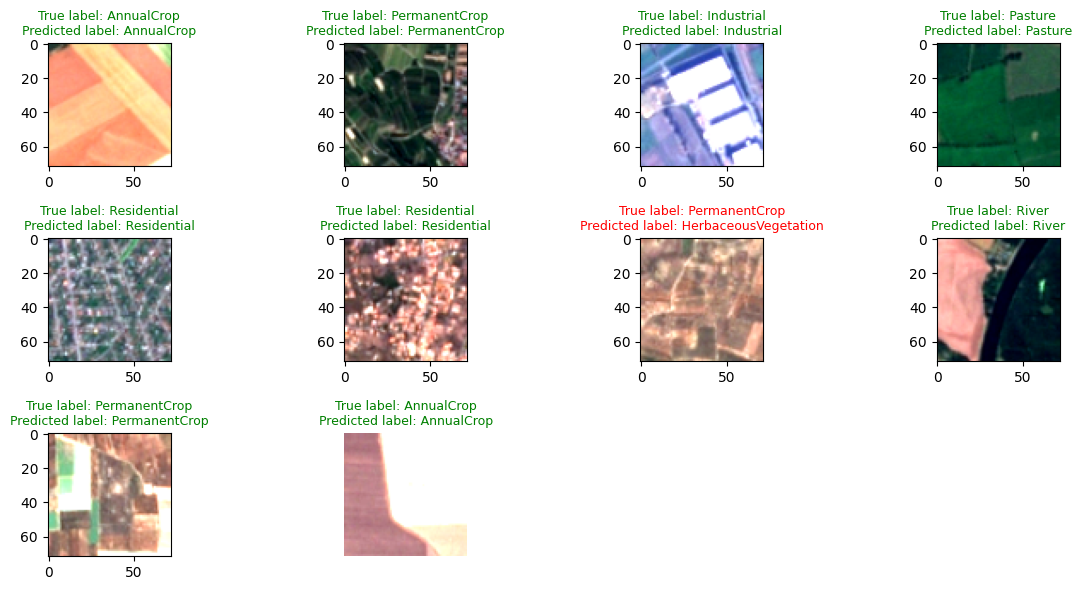

In [49]:
# Show test images with predictions
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plot_images(images.cpu(), labels, classes, preds=preds.cpu(), num_images=10)


In [56]:

summary(model, input_size=(1, 3, 72, 72))


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Conv2d: 1, BatchNorm2d: 1, ReLU: 1, Conv2d: 1, BatchNorm2d: 1, ReLU: 1, Dropout: 1, Flatten: 1]

# Architecture with all layers active


==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
BaseCNN                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 72, 72]           896
├─BatchNorm2d: 1-2                       [1, 32, 72, 72]           64
├─ReLU: 1-3                              [1, 32, 72, 72]           --
├─MaxPool2d: 1-4                         [1, 32, 36, 36]           --
├─Conv2d: 1-5                            [1, 64, 36, 36]           18,496
├─BatchNorm2d: 1-6                       [1, 64, 36, 36]           128
├─ReLU: 1-7                              [1, 64, 36, 36]           --
├─MaxPool2d: 1-8                         [1, 64, 18, 18]           --
├─Flatten: 1-9                           [1, 20736]                --
├─Linear: 1-10                           [1, 128]                  2,654,336
├─ReLU: 1-11                             [1, 128]                  --
├─Linear: 1-12                           [1, 10]                   1,290
==========================================================================================
Total params: 2,675,210
Trainable params: 2,675,210
Non-trainable params: 0
Total mult-adds (M): 31.27
==========================================================================================
Input size (MB): 0.06
Forward/backward pass size (MB): 3.98
Params size (MB): 10.70
Estimated Total Size (MB): 14.75
==========================================================================================

# Architecture when Pooling is removed

### Loading the Dataset EuroSAT dataset

# Provide your answers to Experiment and Reflection

### - What choices affect the model's accuracy?



### - How do you determine whether the model is  overfitting or underfitting?



### - What happens when you add or remove components, for example, dropout or batch normalization?

#### if the Dropout layer is removed the Model overfits in early epoch the validation Loss is oscilating up and down above train loss. The model learns faster whith all neurons activated but sees the train data to mutch and overfits to it very quick.

If the Batch Norm is removed the Model also overfits but not as quick as it was when removing dropout, the validatation loss is oscilating above training lose

### - What layer causes the highest number of parameters?
 #### its fullt connected linear layer 1 with  2,654,336 parameters

### - what happens if you remove all pooling layers in a CNN?
The feature map isnt decreasing and the flatten size gets bigger 64*72*72= 331 776 features should been 64*18*18 = 20736 features and that is what the first linear layer expext sow gets an runtime error


### - In a CNN block, can you arrange the layer (i.e. Conv, ReLU, BatchNorm, Dropout) in any order? Explain your answer.